In [1]:
import gym
import numpy as np
import time
from matplotlib import pyplot as plt

In [2]:
class Agent():
    def __init__(self, env, total_episodes, step_limit, epsilon, epsilon_decay,
                 min_epsilon, gamma, alpha, alpha_decay, min_alpha):
        self.env = env
        self.action_space = env.action_space.n
        self.observation_space = env.observation_space.n
        self.qtable = np.zeros((self.observation_space, self.action_space))
        self.total_rewards = []
        self.total_steps = []
        self.total_episodes = total_episodes
        self.step_limit = step_limit
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.min_alpha = min_alpha
    
    def alpha_schedule(self, episode):
        if (episode + 1) % 1000 == 0:
            self.alpha *= self.alpha * self.alpha_decay
            self.alpha = max(self.alpha, self.min_alpha)
    
    def epsilon_schedule(self, episode):
        if (episode + 1) % 1000 == 0:
            self.epsilon *= self.epsilon * self.epsilon_decay
            self.epsilon = max(self.epsilon, self.min_epsilon)
    
    def learn(self, state_old, state_new, reward, action):
        prediction = self.qtable[state_old, action]
        target = reward + self.gamma * np.max(self.qtable[state_new, :])
        self.qtable[state_old, action] = self.qtable[state_old, action] + self.alpha * (target - prediction)
    
    def choose_action(self, state):
        action = 0
        if np.random.uniform(0, 1) < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = np.argmax(self.qtable[state, :])
        return action
    
    def train(self):
        episode_print_split = self.total_episodes // 5
        for episode in range(self.total_episodes):
            state = self.env.reset()
            t = 0
            done = False
            self.alpha_schedule(episode)
            self.epsilon_schedule(episode)
            for t in range(step_limit):
                action = self.choose_action(state)
                state_new, reward, done, info = self.env.step(action)
                self.learn(state, state_new, reward, action)
                state = state_new
                t += 1
                if done:
                    self.total_rewards.append(reward)
                    self.total_steps.append(t)
                    if (episode + 1) % episode_print_split == 0:
                        if reward > 0.0:
                            outcome = 'win'
                        else:
                            outcome = 'lose'
                        print(f'Episode {episode} | {t} steps | {outcome}')
                    break
        print('')
        total_win_rate = sum(self.total_rewards) / self.total_episodes
        print(f'Total win rate {total_win_rate}')

    def moving_average(self, window):
        weights = np.repeat(1.0, window) / window
        simple_moving_average = np.convolve(self.total_rewards, weights, 'valid')
        return simple_moving_average

In [16]:
total_episodes = 100000
step_limit = 100 # max steps per episode
epsilon = 1
epsilon_decay = 0.2
min_epsilon = 1e-4
gamma = 0.95
alpha = 0.8
alpha_decay = 0.3
min_alpha = 1e-4

env = gym.make('FrozenLake-v1')
frozenlake = Agent(env, total_episodes, step_limit, epsilon, epsilon_decay,
                 min_epsilon, gamma, alpha, alpha_decay, min_alpha)
frozenlake.train()

Episode 19999 | 28 steps | win
Episode 39999 | 42 steps | lose
Episode 59999 | 69 steps | win
Episode 79999 | 81 steps | lose
Episode 99999 | 37 steps | lose

Total win rate 0.71756


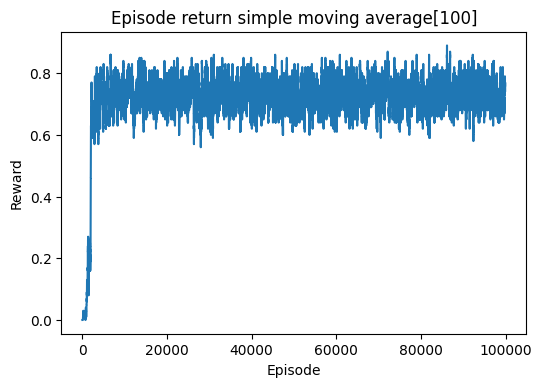

In [17]:
window = 100
average_reward = frozenlake.moving_average(window)

plt.figure(dpi = 100)
plt.title(f'Episode return simple moving average[{window}]')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.plot(average_reward)